# Desafío - Naive Bayes
- Para realizar este desafío debes haber estudiado previamente todo el material disponibilizado correspondiente a la unidad.
- Una vez terminado el desafío, comprime la carpeta que contiene el desarrollo de los requerimientos solicitados y sube el .zip en el LMS.
- Desarrollo desafío:
    - El desafío se debe desarrollar de manera Individual.
    - Para la realización del desafío necesitarás apoyarte del archivo Apoyo Desafío - Naive Bayes.

## Descripción
- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump dentro del proyecto.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, se les pide un modelo generativo que pueda predecir el género de una canción a partir de la letra de una canción.
- Existen 4 géneros que se registran en la base de datos.
- Se busca predecir el género en base a las frecuecias de palabras de cada canción, por lo que para esta actividad trabajaremos con un Multinomial Naive Bayes.

### Ejercicio 1: Preparar el ambiente de trabajo
- Importe los módulos `numpy`, `pandas`, `matplotlib`, `seaborn`, `glob` y `os` siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta `dump`.
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en `dump` utilizando `glob.glob` y `os.getcwd()` para extraer las rutas absolutas.
- Posteriormente generé un objeto `pd.DataFrame` que contenga todos los `csv`.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
# Utiliza esta celda para realizar los import solicitados.
# Triada calsica.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Graficos seaborn, warnings y datos perdidos.
import seaborn as sns
import warnings
import missingno as msngo

# Importaciones especificas de este desafio.
import glob, os

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

# Otras librerias, configuraciones e instancias.
labelencoder = LabelEncoder()
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('seaborn-darkgrid')

In [2]:
# Utiliza esta celda para crear el DataFrame solicitado

archivos = glob.glob('dump/*.csv')

df_acum = pd.DataFrame()
for archivo in archivos:
    df = pd.read_csv(archivo)
    df_acum = df_acum.append(df)

df_acum = df_acum.reset_index(drop=True).drop(columns='Unnamed: 0')
df_acum.columns = ['artista', 'genero', 'cancion', 'lyric']

In [3]:
df_acum

,artista,genero,cancion,lyric
0,Public Enemy,hiphop,You're Gonna Get Yours,"(Flavor Flav) \n Oh-oh Chuck, they out to get ..."
1,Public Enemy,hiphop,Sophisticated Bitch,"That woman in the corner, cold playin' the rol..."
2,Public Enemy,hiphop,Miuzi Weighs A Ton,"Yo Chuck, run a power move on them \n (Yeah) \..."
3,Public Enemy,hiphop,Timebomb,"(Intro - Flavor Flav) \n Hey, Chuck, we got so..."
4,Public Enemy,hiphop,Too Much Posse,(Intro - Flavor Flav) \n What do you got to sa...
...,...,...,...,...
9484,Mos Def,hiphop,Travellin' Man,Yeah yo yo what time the plane leavin'? \n Ah ...
9485,Mos Def,hiphop,Universal Magnetic,"(Mos Def) \n Yeah, ha ha ha \n A-B-boys rock t..."
9486,Mos Def,hiphop,Very Well,So what you doing \n I'm feeling very well \n ...
9487,Mos Def,hiphop,What's Beef?,(Talib Kweli) \n Yo I was sold to a sick Europ...


In [4]:
df_acum.isna().sum()

artista    0
genero     0
cancion    0
lyric      0
dtype: int64

### Ejercicio 2: Descripción de los datos
- Utilizando el objeto creado en el Ejercicio 1, genere dos gráficos de barras que resuman la siguiente información:
    - La cantidad de canciones registradas por cada artista, ordenados de mayor a menor.
    - La cantidad de canciones registradas en cada género, ordenados de mayor a menor.
- Comente sobre las principales tendencias.

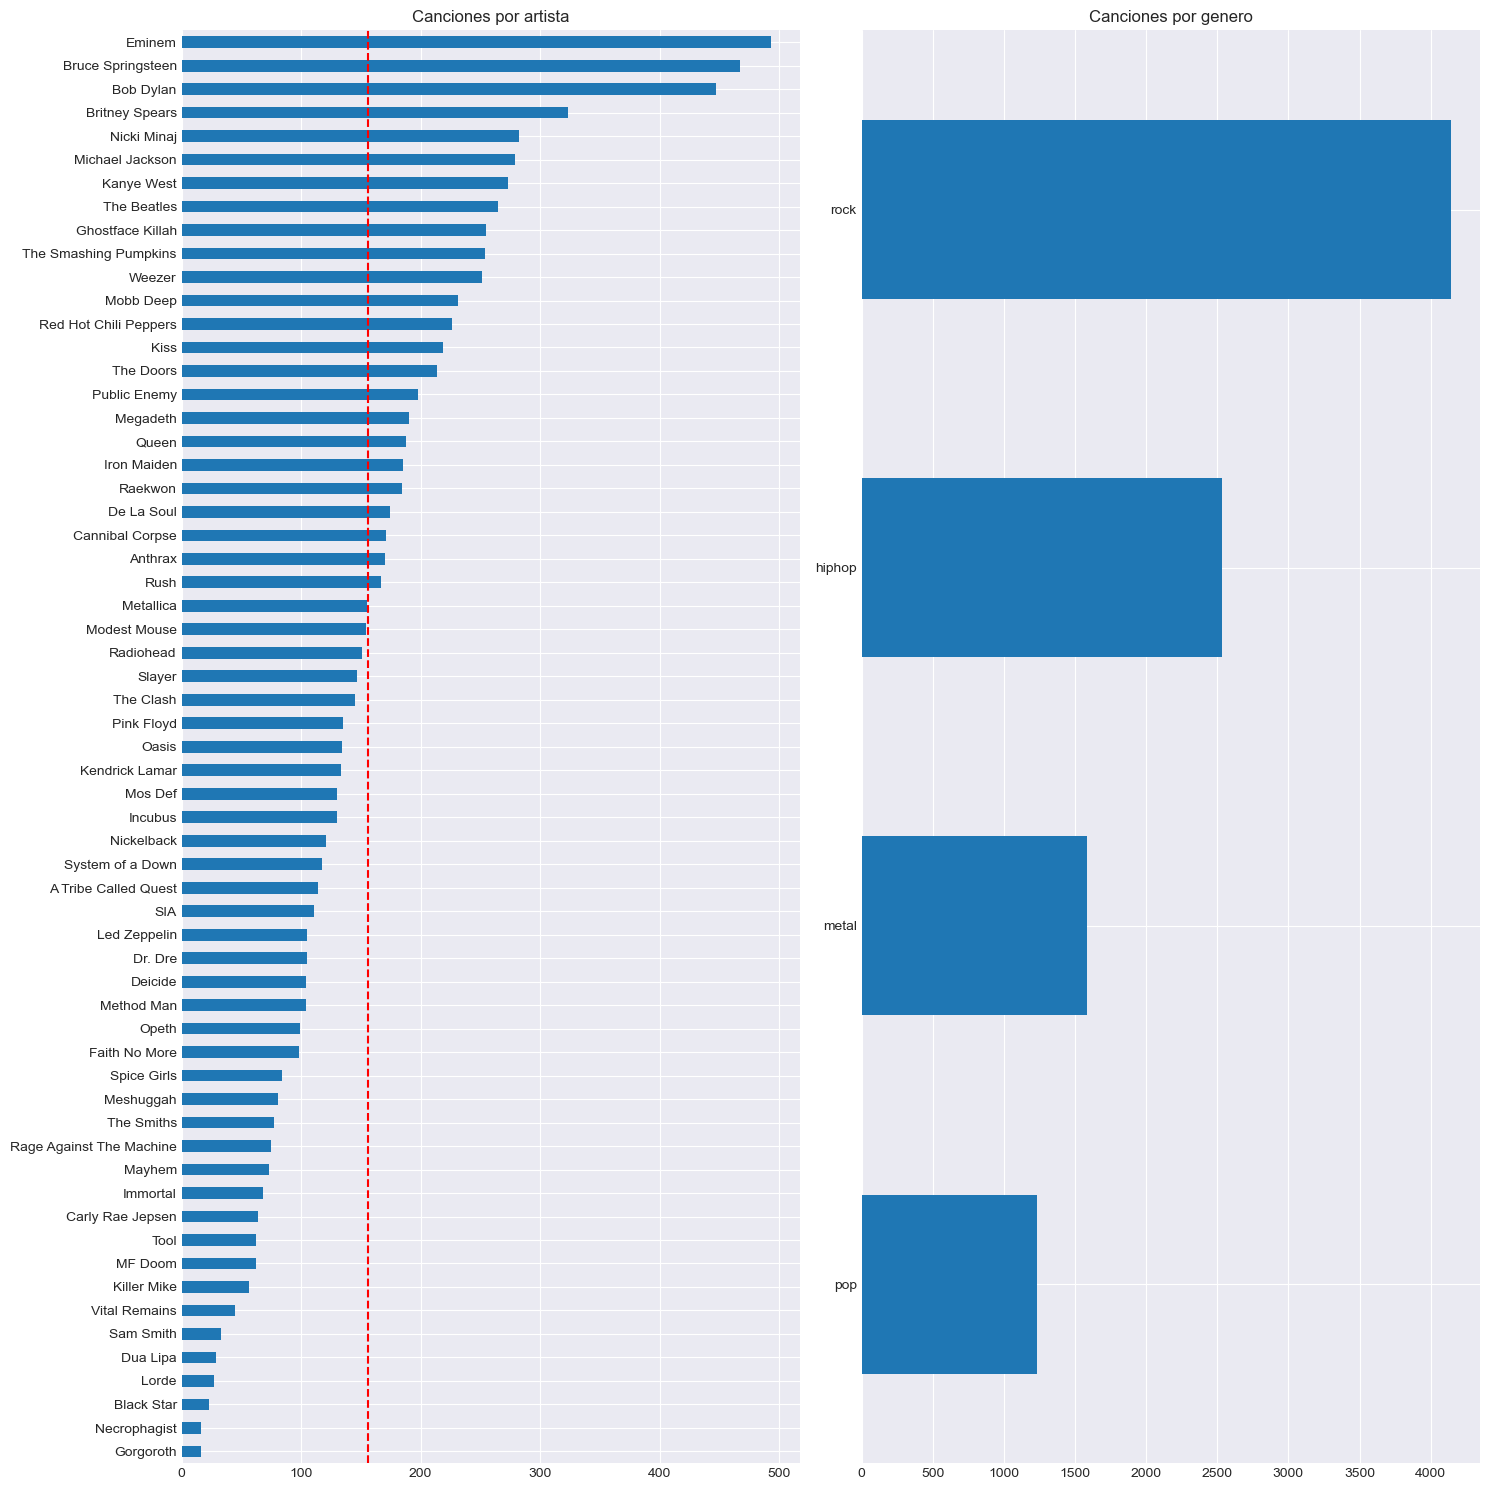

In [5]:
# Utiliza esta celda para el primer gráfico solicitado

#df_acum.groupby('artista')['cancion'].count().sort_values(ascending=False)

#sns.barplot(x = df_acum['artista'].value_counts().index, y = df_acum['artista'].value_counts().values)

plt.figure(figsize=(15,15))

plt.subplot(1,2,1)
df_acum['artista'].value_counts().sort_values().plot(kind='barh')
plt.title('Canciones por artista')
plt.axvline(df_acum['artista'].value_counts().mean(), color='red', ls='--')

plt.subplot(1,2,2)
df_acum['genero'].value_counts().sort_values().plot(kind='barh')
plt.title('Canciones por genero')

plt.tight_layout();

**Comentarios**

### Ejercicio 3: Matriz de ocurrencias

#### Digresión: Tokenización de Textos
Para poder trabajar con textos, debemos pasarlos a una matriz dispersa, donde cada fila representará una entrada (en este caso, una canción), y cada columna representará una palabra (token). Este es el proceso de tokenización: Identificar la ocurrencia de una palabra específica dentro de un conjunto de textos (corpus).

El tokenizador más simple `sklearn.feature_extraction.text.CountVectorizer` genera una colección de textos a una matriz que representa la frecuencia dentro del texto de una palabra específica.

- Importe la clase `CountVectorizer` dentro de los módulos `feature_extraction.text` de la librería `sklearn`. Lea la documentación asociada a ésta. ¿Cuál es el objetivo de esta clase?

**Respuesta**:

In [6]:
#Utiliza esta celda
from sklearn.feature_extraction.text import CountVectorizer

- Aplique la clase para extraer las 100 palabras más repetidas en toda la base de datos

In [7]:
#Utilice esta celda.
count_vectorizer = CountVectorizer(stop_words='english', max_features=100)
count_vectorizer_fit = count_vectorizer.fit_transform(df_acum['lyric'])

In [8]:
words = count_vectorizer.get_feature_names()

In [9]:
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

In [10]:
df_words = pd.DataFrame(zip(words, words_freq), columns = ['word', 'freq'])

#Otra forma:
#df_words = pd.DataFrame([words, words_freq]).T

In [11]:
df_words.sort_values(by='freq', ascending=False)

,word,freq
51,like,19629
18,don,17398
44,know,14962
31,got,14171
43,just,13978
...,...,...
15,death,1897
47,left,1895
82,thing,1882
20,end,1829


- Genere una función que replique el procedimiento para cada uno de los géneros

In [12]:
# Utiliza esta celda para definir la función solicitada

def vectorize_by_genre(df, genero='rock', objetivo='lyric', stop_words_ = 'english', plot=False):
    
    """
    Devuelve una matriz dispersa para analisis de texto.
    """
    
    df_tmp = df.copy()
    count_vectorizer = CountVectorizer(stop_words=stop_words_, max_features=100)
    count_vectorizer_fit = count_vectorizer.fit_transform(df_tmp[df_tmp['genero'] == genero][objetivo])
    
    words = count_vectorizer.get_feature_names()
    words_freq = count_vectorizer_fit.toarray().sum(axis=0)
    
    df_words = pd.DataFrame(zip(words, words_freq), columns = ['word', 'freq']).sort_values(by='freq', ascending=False)
    
    if plot == True:
        plt.figure(figsize=(25,7)) #No funciona ahi.
        sns.barplot(df_words['word'], df_words['freq']) 
        plt.title(genero)
        plt.xticks(rotation=90)
        
    return df_words

- Comente sobre las principales características de cada género en cuanto a sus palabras.

In [13]:
vectorize_by_genre(df_acum, genero='hiphop', plot=True)

TypeError: barplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 2500x700 with 0 Axes>

In [ ]:
# Utiliza esta celda para hacer el llamado a la función para cada género. Tip: Usar unique() y un ciclo for. 
# Se puede mostrar las frecuencias usando plt.bar
import warnings
warnings.simplefilter('ignore')
for genero_ in df_acum['genero'].unique():
    
    vectorize_by_genre(df_acum, genero=genero_, plot=True)

**Comentarios**

### Ejercicio 4: Entrenamiento del Modelo

#### Digresión: sklearn Pipelines
La clase Pipeline del módulo `sklearn.pipeline` permite concatenar múltiples pasos de procesamiento y preprocesamiento en un estimador generado por algún método de scikit-learn. En sí, la clase cuenta con los métodos clásicos `fit`, `predict` y `score` y presenta un comportamiento idéntico a los demás objetos de scikit-learn. Uno de los usos más comunes es para concatenar pasos de preprocesamiento con un modelo. _Esto es especialmente útil cuando se quiere automatizar el uso de un modelo en producción_.

#### Componentes de un Pipeline
Imaginemos que deseamos implementar el siguiente modelo. Considerando un conjunto de datos, deseo Estandarizar, posteriormente extraer sus principales componentes y finalmente aplicar un modelo de regresión lineal. Este flujo se puede reexpresar como:
```python
pipeline_model = Pipeline([                      # Pipeline recibe una lista de tuplas, donde cada tupla tiene una etiqueta y un paso a realizar
    ('scale', StandardScaler()),                 # Paso 1: Estandarizar los datos
    ('pca', RandomizedPCA(n_components=3)),      # Paso 2: Aplicar PCA
    ('model', LinearRegression())                # Paso 3: Ajustar un modelo de regresión lineal
])
```

**Algunos de los elementos a considerar**:
- Cada paso se considera como una tupla, donde se declara el nombre del paso y la función a implementar. En este caso, nuestro primer paso es estandarizar la matriz, por lo que asociamos el método `StandardScaler` con el string `'scale'`.
- Todos los pasos declarados se incorporan en una lista, donde el orden de ingreso representa el orden de ejecución.

Posteriormente el objeto creado puede utilizarse con los siguientes métodos
- `pipeline_model.fit(X_train, y_train)`
- `y_hat = pipeline_model.predict(X_test)`

- Importe `MultinomialNB`, `train_test_split`, `Pipeline` y `classification_report`.

In [14]:
X = df_acum['lyric']
y = df_acum['genero']

In [17]:
X.shape

(9489,)

In [18]:
y.shape

(9489,)

- Genere las muestras de entrenamiento y validación reservando un 33% para validación y declarando una semilla pseudoaleatoria.

In [ ]:
# Utiliza esta celda para generar las muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .33, random_state= 11238)

- Monte el modelo dentro de un `Pipeline`, donde el primer paso es implementar `CountVectorizer` y el segundo es ejecutar el clasificador `MultinomialNB` con `alpha=0.1`.

In [ ]:
# Utiliza esta celda para crear el Pipeline solicitado y entrenarlo
pipeline_model = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),('multinomial', MultinomialNB(alpha=0.1))])
pipeline_model.fit(X_train, y_train)

- A continuación se les presenta una lista de letras, ¿cuáles serían las predicciones correspondientes?

```python
[
    'I got a place in the underworld', # Brody Dalle - Underworld
    'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
    "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
    'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move Btch
    "Sexual violence doesn't start and end with rape It starts in our books and behind our school gate" # IDLES - Mother,
    "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to \
    build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting\
    You are not deserving, you are not deserving" #Banks - Drowning
]
```

In [ ]:
# Utiliza esta celda para realizar las predicciones para la lista de letras entregada

pipeline_model.predict([
    'I got a place in the underworld', # Brody Dalle - Underworld
    'As veils of ignorance, hatred retains Storm of arrows through karma Seeking light through samsara', # Gorguts - Forgotten Arrows
    "Bye bye Don't want to be a fool for you Just another player in your game for two You may hate me but it ain't no lie", # N'SYNC - Bye Bye Bye
    'Move bitch, get out the way Get out the way bitch, get out the way Move bitch, get out the way Get out the way bitch, get out the way', # Ludacris - Move Btch
    "Sexual violence doesn't start and end with rape It starts in our books and behind our school gate", # IDLES - Mother
    "Take it from the girl you claimed to love You gonna get some bad karma I'm the one who had to learn to \
    build a heart made of armor From the girl who made you soup and tied your shoes when you were hurting\
    You are not deserving, you are not deserving" #Banks - Drowning
])

In [ ]:
pipeline_model.predict(['death', 'baby'])

- Genere una predicción implementando la muestra de test y contraste las predicciones del modelo con las etiquetas verdaderas. Reporte las principales métricas.

In [ ]:
# Utiliza esta celda para generar las predicciones en los datos de validación

y_hat = pipeline_model.predict(X_test)

In [ ]:
# Utiliza esta celda para reportar las métricas
print(classification_report(y_hat, y_test))

**Comentarios**

### Ejercicio 5: Mejora del Modelo
- Proponga una estrategia para mejorar el desempeño del modelo en la categoría con peores métricas.
- Repita los pasos de entrenamiento y reporte de métricas, esta vez incluyendo los nuevos datos suministrados.
- Comente sobre el desempeño general de este.

In [ ]:
# Utiliza esta celda para crear un nuevo df de lyrics en base a las letras en dump_plus_pop

archivos = glob.glob('dump_plus_pop/*.csv')

df_acum_plus_pop = pd.DataFrame()
for archivo in archivos:
    df = pd.read_csv(archivo)
    df_acum_plus_pop = df_acum_plus_pop.append(df)

df_acum_plus_pop = df_acum_plus_pop.reset_index(drop=True).drop(columns='Unnamed: 0')
df_acum_plus_pop.columns = ['artista', 'genero', 'cancion', 'lyric']

In [ ]:
# Utiliza esta celda para dividir las muestras y entrenar el pipeline

X = df_acum_plus_pop['lyric']
y = df_acum_plus_pop['genero']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .33, random_state= 11238)

pipeline_model_plus_pop = Pipeline([('vectorizer', CountVectorizer(stop_words='english')),('multinomial', MultinomialNB(alpha=0.1))])
pipeline_model_plus_pop.fit(X_train, y_train)

In [ ]:
# Utiliza esta celda para mostrar las métricas de desempeño de nuevo modelo

y_hat_plus_pop = pipeline_model_plus_pop.predict(X_test)

In [ ]:
print(classification_report(y_hat_plus_pop, y_test))